In [ ]:
import pandas as pd
import numpy as np

In [ ]:
!pip install datasets transformers seqeval

     |████████████████████████████████| 245kB 8.5MB/s 
     |████████████████████████████████| 2.5MB 38.6MB/s 
     |████████████████████████████████| 51kB 8.0MB/s 
     |████████████████████████████████| 122kB 47.0MB/s 
     |████████████████████████████████| 245kB 48.0MB/s 
     |████████████████████████████████| 901kB 46.0MB/s 
     |████████████████████████████████| 3.3MB 48.4MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp37-none-any.whl size=16184 sha256=ada38ff7dec72df1c893358d74c16c2751249a9627717be3e761a0976c706d75
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built seqeval


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Data Preproccessing 

(globally + for Tag Classification)

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/py3@k_бот_генератор_новостей/lenta-ru-news.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df.shape

(800975, 6)

In [ ]:
df = df.dropna()

In [ ]:
df = df[df['tags'] != 'Все']

In [ ]:
df.shape

(259073, 6)

In [ ]:
df = df.groupby(['tags']).filter(lambda x: len(x) > 40)

In [ ]:
import collections
c = collections.Counter(' '.join([x for x in df['tags'].to_list()]).split())

In [ ]:
# nolist_tags = ['Молдавия', 'Украина', 'Белоруссия', 'Прибалтика', 'Софт']

In [ ]:
df2 = pd.DataFrame(columns = list(df.columns))
for tag in df['tags'].unique():
    n = int(c[tag] * 0.5)
    if n > 1500:
      n = 1500
      df2 = pd.concat([df2, df[df['tags'] == tag].sample(n)])
    elif n > 60:
      df2 = pd.concat([df2, df[df['tags'] == tag].sample(n)])

In [ ]:
df2.shape

(51325, 6)

In [ ]:
import collections
c2 = collections.Counter(' '.join([x for x in df2['tags'].to_list()]).split())
c2

Counter({'Coцсети': 1462,
         'Авто': 70,
         'Автобизнес': 155,
         'Белоруссия': 458,
         'Бизнес': 1500,
         'Вещи': 212,
         'Гаджеты': 1091,
         'Город': 1123,
         'Госэкономика': 1500,
         'Дача': 542,
         'Движение': 417,
         'Деньги': 680,
         'Достижения': 359,
         'Еда': 228,
         'Жизнь': 166,
         'Закавказье': 721,
         'Звери': 1139,
         'Игры': 1036,
         'Инструменты': 355,
         'Интернет': 1500,
         'Искусство': 897,
         'История': 173,
         'Квартира': 1500,
         'Киберпреступность': 84,
         'Кино': 1500,
         'Книги': 604,
         'Конфликты': 1500,
         'Космос': 1500,
         'Криминал': 1275,
         'Люди': 1500,
         'Мемы': 238,
         'Мир': 1060,
         'Мнения': 307,
         'Молдавия': 219,
         'Москва': 656,
         'Музыка': 1500,
         'Наука': 1500,
         'Общество': 1500,
         'Оружие': 608,
         'Офис

In [ ]:
num_labels = len(df2['tags'].unique())
num_labels

59

In [ ]:
sum(list(c2.values()))

51325

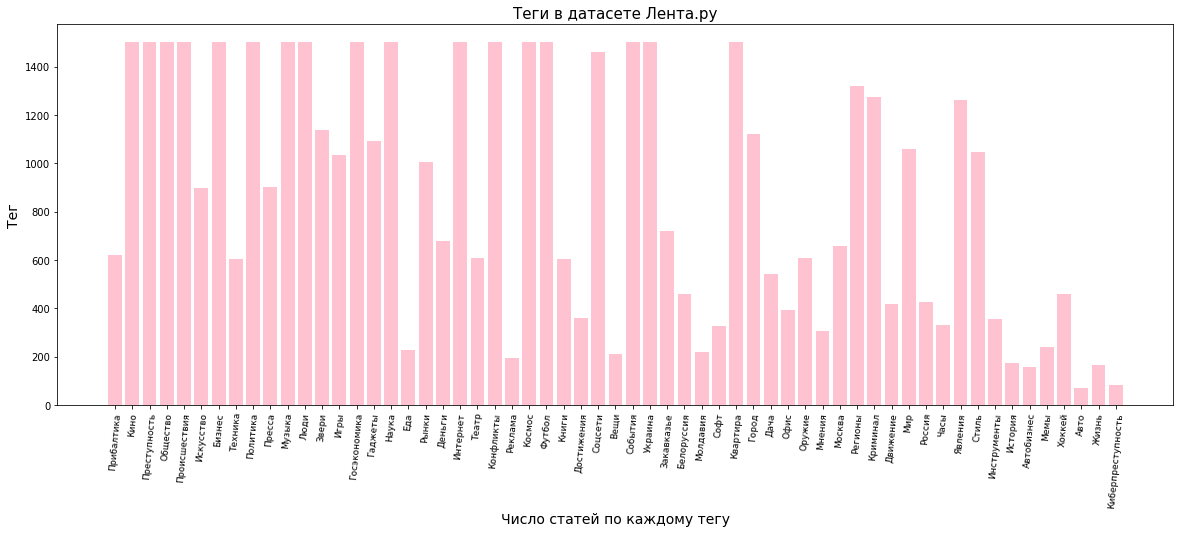

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 7))
plt.bar(c2.keys(),
            c2.values(),
           color='#FEC2D1')
plt.ylabel('Тег', size=14)
# plt.ylim((0,14500))
plt.xlabel('Число статей по каждому тегу', size=14)
plt.xticks(rotation=85, size=9)
plt.title('Теги в датасете Лента.ру', size=15)
plt.show()

In [ ]:
l = df2.shape[0]

In [ ]:
from sklearn import preprocessing

def LabelEncoding(df, column_name):
  df[column_name+'_nums'] = df[column_name]
  le = preprocessing.LabelEncoder()
  le.fit(df[column_name+'_nums'])
  df[column_name+'_nums'] = le.transform(df[column_name+'_nums'])
  return df, le

df, le = LabelEncoding(df2, 'tags')

In [ ]:
num_classes = len(le.classes_)
num_classes

59

In [ ]:
dict_le = {}
for i in range(60):
  dict_le[le.transform([le.classes_[i]])[0]] = le.classes_[i]

In [ ]:
df['label'] = df['tags_nums']

In [ ]:
df = df.drop(columns=['tags_nums', 'url'], axis=0)

In [ ]:
df.sample()

,title,text,topic,tags,date,label,tags_nums
712339,Индийцы устали ездить внутри Т-90 и установили...,На учениях в Индии замечен танк Т-90С «Бхишма»...,Наука и техника,Оружие,2018/05/11,38,36


## Tokenize

In [ ]:
# model_checkpoint = "bert-base-multilingual-uncased"
model_checkpoint = "bert-base-multilingual-cased"
from transformers import AutoTokenizer
    
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [ ]:
def tokenize_text(examples):
      tokenized_inputs = tokenizer(examples, truncation = True, max_length=300)['input_ids']
      return tokenized_inputs

In [ ]:
tokenize_text(['привет как длеа'])

[[101, 10913, 41102, 10949, 545, 11851, 10179, 102]]

In [ ]:
df['text_num'] = df['text'].apply(tokenize_text)

In [ ]:
max_length = 300

def preprocess_text_2(text):
    tokens_left = text
    if len(tokens_left) >= max_length:
        return tokens_left[:max_length]
    else:
        pads = [0] * (max_length - len(tokens_left))
        return tokens_left + pads

In [ ]:
df['text_num2'] = df['text_num'].map(preprocess_text_2)

## DataLoader

In [ ]:
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):
    def __init__(self, df):
        self.texts = df['text_num2'].values
        self.targets = df['label'].values

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        target = self.targets[idx]
        return torch.tensor(text), torch.tensor(target)


In [ ]:
from sklearn.model_selection import train_test_split
train_big_df, test_df = train_test_split(df, test_size=0.2)

In [ ]:
train_df, val_df = train_test_split(train_big_df, test_size=0.1, random_state = 42)

In [ ]:
train_dataset = TextDataset(train_df)
val_dataset = TextDataset(val_df)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
import torch 
from torch import nn

# Tag Classification

## Beast Model_1

In [ ]:
class BeastModel_1(nn.Module):
    def __init__(self, seq_len, vocab_size, hidden_sizes=[100, 64, 128, 256, 256, 64, 60]):
        self.hidden_sizes = hidden_sizes
        self.seq_len = seq_len
        super().__init__()
        
        self.embed = nn.Embedding(vocab_size, self.hidden_sizes[0])
        self.lstm = nn.LSTM(self.hidden_sizes[0], self.hidden_sizes[1], num_layers=2, batch_first=True, bidirectional=True)
        
        self.fc_1 = nn.Sequential(nn.Linear(self.hidden_sizes[2], self.hidden_sizes[3]), nn.LeakyReLU())
        self.fc_2 = nn.Sequential(nn.Linear(self.hidden_sizes[3], self.hidden_sizes[4]), nn.LeakyReLU())
        self.fc_3 = nn.Sequential(nn.Linear(self.hidden_sizes[4], self.hidden_sizes[5]), nn.LeakyReLU())
        self.fc_4 = nn.Sequential(nn.Linear(self.hidden_sizes[5], self.hidden_sizes[6]))
        
        self.linear_layers = nn.Sequential(self.fc_1, self.fc_2, self.fc_3, self.fc_4)

    def forward(self, x):
        x = self.embed(x)
        x = self.lstm(x)[1][1]
        x = x.view(x.shape[0] // 2, 2, x.shape[1], x.shape[2])
        x = x[1].permute(1, 0, 2).flatten(1)
        
        return self.linear_layers(x)

In [ ]:
model = BeastModel_1(300,  len(tokenizer.vocab)).cuda()
CELoss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
def save_model_and_optimizer(model, optimizer, DIR):
    torch.save(model.state_dict(), DIR + '/model.pt')
    torch.save(optimizer.state_dict(), DIR + '/optimizer.pt')

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
def accuracy_topk(preds, targets, topk=(3,)):
    """
Computes the accuracy over the k top predictions for the specified values of k
output and targets are just tensors.
"""
    maxk = max(topk)
    batch_size = targets.size(0)
    values, indices = torch.topk(preds, maxk, dim=1)
    targets2 = [np.zeros(3)] * targets.shape[0]
    for i in range(len(targets2)):
      targets2[i] = [targets[i].item()]* 3
    targets2 = torch.tensor(targets2)
    correct = (targets2.cuda() == indices)
    ans = 0
    for line in correct:
      if True in line:
        ans += 1
    return ans

In [ ]:
def count_accuracy(epoch):
    accuracy = 0
    top3_accuracy = 0
    summ = 0
    for i, batch in enumerate(tqdm(val_dataloader)):
        if i % 1000 == 0 and i != 0:
            print(f"\t {i/len(val_dataloader) * 100}%")
        batch = [i.float().cuda() for i in batch]
        texts, targets = batch
        texts = texts.type(torch.cuda.LongTensor)
        targets = targets.type(torch.cuda.LongTensor)
        preds = model(texts)
        accuracy += (targets == preds.argmax(1)).sum()
        top3_accuracy += accuracy_topk(preds, targets, topk=(3,))
        summ += len(targets)
    accuracy = accuracy.type(torch.cuda.FloatTensor)
    accuracy /= summ
    accuracy = accuracy.detach().cpu().numpy()
    top3_accuracy /= summ
    print('\t Accuracy: ', accuracy, '\n', '\t Top-3 Accuracy: ', top3_accuracy)
    # tb.add_scalar("Val accuracy", accuracy, epoch)

In [ ]:
epoch = 0
num_epochs = 5
while epoch < num_epochs:
    for i, batch in enumerate(tqdm(train_dataloader)):
        if i % 300 == 0:
            print(i)
        batch = [i.float().cuda() for i in batch]
        texts, targets = batch
        texts = texts.type(torch.cuda.LongTensor)
        targets = targets.type(torch.cuda.LongTensor)
        preds = model(texts)
        loss = CELoss(preds, targets)
        #tb.add_scalar("Train CE", loss.detach().cpu().numpy(), epoch * len(train_dataloader) + i)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    count_accuracy(epoch * len(train_dataloader) + i)
    epoch += 1

0
300
600
900
1200




	 Accuracy:  0.28428736 
 	 Top-3 Accuracy:  0.48809066461774875


0
300
600
900
1200




	 Accuracy:  0.40453324 
 	 Top-3 Accuracy:  0.641567422205148


0
300
600
900
1200




	 Accuracy:  0.4873223 
 	 Top-3 Accuracy:  0.7339608144448713


0
300
600
900
1200




	 Accuracy:  0.5055705 
 	 Top-3 Accuracy:  0.7475989243180945


0
300
600
900
1200




	 Accuracy:  0.52669996 
 	 Top-3 Accuracy:  0.7658470995005763


In [ ]:
save_model_and_optimizer(model, optimizer, '/content/gdrive/MyDrive/py3@k_бот_генератор_новостей/models/tags/Beast1')

In [ ]:
model = BeastModel_1(300,  len(tokenizer.vocab))
model.load_state_dict(torch.load('/content/gdrive/MyDrive/py3@k_бот_генератор_новостей/models/tags/Beast1/model.pt'))

<All keys matched successfully>

In [ ]:
import ast
file = open("/content/gdrive/MyDrive/py3@k_бот_генератор_новостей/dict_le.txt", "r")

contents = file.read()
dict_le = ast.literal_eval(contents)

In [ ]:
text_trial = """Новая методика лечения последствий коронавируса зарегистрирована в Германии. Её автором стал пульмонолог больницы в Шверине Рихард Хольбрих, решивший пренебречь стандартными протоколами лечения и использовать в качестве основного препарата пиво. 
Согласно результатам исследований, из 3 тысяч пациентов с COVID-19 с начала года, которых вёл Хольбрих, ни один из них не умер, а реабилитация больных проходила вдвое быстрее, чем у других заболевших. Несмотря на слабую доказательную базу метода, эксперты Минздрава ФРГ признали терапию эффективной.

«Я считаю, что главное - мотивировать организм побеждать болезнь, а для этого лечение должно быть приятным. Пациенты видят стимул. Что интересно, то пиво отлично принимали даже больные, введённые в состояние искусственной комы. Буквально 2-3 дня и мы переводили их с аппаратов ИВЛ в обычную палату», - рассказал доктор.
Хольбрих предупредил, что самостоятельно лечиться пивом не стоит, поскольку человек точно не сможет назначить себе терапию. Только врач, опираясь на результаты анализов, сможет принять правильное решение в отношении марки и количества хмельного напитка."""


# model_checkpoint = "bert-base-multilingual-cased"
# from transformers import AutoTokenizer
    
# tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
def tokenize_text(examples):
      tokenized_inputs = tokenizer(examples, truncation = True, max_length=300)['input_ids']
      return tokenized_inputs
max_length = 300

def preprocess_text_2(text):
    tokens_left = text
    if len(tokens_left) >= max_length:
        return tokens_left[:max_length]
    else:
        pads = [0] * (max_length - len(tokens_left))
        return tokens_left + pads
input_text = preprocess_text_2(tokenize_text(text_trial))

In [ ]:
num_tags = 5
_, indices = torch.topk(model(torch.tensor(input_text).resize_((1,1))), k=num_tags, dim=1)
ans = []
for ind in indices.tolist()[0]:
  ans.append(dict_le.get(ind))
print(ans)

['Люди', 'Явления', 'Искусство', 'Стиль', 'Вещи']


In [ ]:
text_trial = "приветики как делишки"
input_text = preprocess_text_2(tokenize_text(text_trial))
num_tags = 5
_, indices = torch.topk(model(torch.tensor(input_text).resize_((1,1))), k=num_tags, dim=1)
ans = []
for ind in indices.tolist()[0]:
  ans.append(dict_le.get(ind))
print(ans)

['Люди', 'Явления', 'Искусство', 'Стиль', 'Вещи']


In [ ]:
text_trial = 'в северной осетии прогремел взрыв'
model_checkpoint = "bert-base-multilingual-cased"
from transformers import AutoTokenizer
    
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
def tokenize_text(examples):
      tokenized_inputs = tokenizer(examples, truncation = True, max_length=300)['input_ids']
      return tokenized_inputs
max_length = 300

def preprocess_text_2(text):
    tokens_left = text
    if len(tokens_left) >= max_length:
        return tokens_left[:max_length]
    else:
        pads = [0] * (max_length - len(tokens_left))
        return tokens_left + pads
input_text = preprocess_text_2(tokenize_text(text_trial))

In [ ]:
num_tags = 3
_, indices = torch.topk(model(torch.tensor(input_text).resize_((1,1))), k=num_tags, dim=1)
ans = []
for ind in indices.tolist()[0]:
  ans.append(dict_le.get(ind))
print(ans)

['Люди', 'Явления', 'Искусство']


In [ ]:
dict_le.get(int(model(torch.tensor(input_text).resize_((1,1))).argmax(1)[0]))

'Люди'

In [ ]:
test_dataset = TextDataset(train_df)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
from tqdm.notebook import tqdm
epoch = 1
for i, batch in enumerate(tqdm(test_dataloader)):
        if i % 300 == 0:
            print(i)
        batch = [i.float().cuda() for i in batch]
        texts, targets = batch
        texts = texts.type(torch.cuda.LongTensor)
        targets = targets.type(torch.cuda.LongTensor)
        preds = model(texts)

In [ ]:
count_accuracy(epoch * len(test_dataloader) + i)


	 Accuracy:  0.55973876 
 	 Top-3 Accuracy:  0.7925470610833654


## Beast  Model_2

In [ ]:
class BeastModel_2(nn.Module):
    def __init__(self, seq_len, vocab_size, hidden_sizes=[100, 64, 128, 256, 256, 64, 60]):
        self.hidden_sizes = hidden_sizes
        self.seq_len = seq_len
        super().__init__()
        
        self.embed = nn.Embedding(vocab_size, self.hidden_sizes[0])

        self.conv1 = nn.Sequential(nn.Conv1d(self.seq_len, self.seq_len // 2, 3), nn.LeakyReLU())
        self.conv2 = nn.Sequential(nn.Conv1d(self.seq_len // 2, self.seq_len // 2, 3), nn.LeakyReLU())
        
        self.conv_layers = nn.Sequential(self.conv1, self.conv2)
        self.lstm = nn.LSTM(self.hidden_sizes[0] - 4, self.hidden_sizes[1], num_layers=2, batch_first=True, bidirectional=True)
        
        self.fc_1 = nn.Sequential(nn.Linear(self.hidden_sizes[2], self.hidden_sizes[3]), nn.LeakyReLU())
        self.fc_2 = nn.Sequential(nn.Linear(self.hidden_sizes[3], self.hidden_sizes[4]), nn.LeakyReLU())
        self.fc_3 = nn.Sequential(nn.Linear(self.hidden_sizes[4], self.hidden_sizes[5]), nn.LeakyReLU())
        self.fc_4 = nn.Sequential(nn.Linear(self.hidden_sizes[5], self.hidden_sizes[6]))
        
        self.linear_layers = nn.Sequential(self.fc_1, self.fc_2, self.fc_3, self.fc_4)

    def forward(self, x):
        x = self.embed(x)
        x = self.conv_layers(x)
        x = self.lstm(x)[1][1]
        x = x.view(x.shape[0] // 2, 2, x.shape[1], x.shape[2])
        x = x[1].permute(1, 0, 2).flatten(1)
        
        return self.linear_layers(x)

In [ ]:
model = BeastModel_2(300,  len(tokenizer.vocab)).cuda()
CELoss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
epoch = 0
num_epochs = 10
while epoch < num_epochs:
    for i, batch in enumerate(tqdm(train_dataloader)):
        if i % 300 == 0:
            print(i)
        batch = [i.float().cuda() for i in batch]
        texts, targets = batch
        texts = texts.type(torch.cuda.LongTensor)
        targets = targets.type(torch.cuda.LongTensor)
        preds = model(texts)
        loss = CELoss(preds, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    count_accuracy(epoch * len(train_dataloader) + i)
    epoch += 1

0
300
600
900
1200




	 Accuracy:  0.19727238 
 	 Top-3 Accuracy:  0.44045332308874374


0
300
600
900
1200




	 Accuracy:  0.3357664 
 	 Top-3 Accuracy:  0.5850941221667307


0
300
600
900
1200




	 Accuracy:  0.40991163 
 	 Top-3 Accuracy:  0.6559738762965809


0
300
600
900
1200




	 Accuracy:  0.44660008 
 	 Top-3 Accuracy:  0.688820591625048


0
300
600
900
1200




	 Accuracy:  0.4623511 
 	 Top-3 Accuracy:  0.7103342297349212


0
300
600
900
1200




	 Accuracy:  0.47022665 
 	 Top-3 Accuracy:  0.7149442950441798


0
300
600
900
1200




	 Accuracy:  0.47887054 
 	 Top-3 Accuracy:  0.7233960814444871


0
300
600
900
1200




	 Accuracy:  0.4738763 
 	 Top-3 Accuracy:  0.7166730695351518


0
300
600
900
1200




	 Accuracy:  0.4794468 
 	 Top-3 Accuracy:  0.711102573953131


0
300
600
900
1200




	 Accuracy:  0.4819439 
 	 Top-3 Accuracy:  0.7130234344986554


In [ ]:
save_model_and_optimizer(model, optimizer, '/content/gdrive/MyDrive/py3@k_бот_генератор_новостей/models/tags/Beast2')

In [ ]:
model = BeastModel_2(300,  len(tokenizer.vocab)).cuda()
model.load_state_dict(torch.load('/content/gdrive/MyDrive/py3@k_бот_генератор_новостей/models/tags/Beast2/model.pt'))

count_accuracy(epoch * len(test_dataloader) + i)


	 Accuracy:  0.5731848 
 	 Top-3 Accuracy:  0.7823665001920861


## Beast Model_3

In [ ]:
from torch.nn import functional as F

In [ ]:
class BeastModel_3(nn.Module):
    def __init__(self, seq_len, vocab_size, hidden_sizes=[100, 100, 100, 256, 128, 32, 60]):
        self.hidden_sizes = hidden_sizes
        self.seq_len = seq_len
        super().__init__()
        
        self.embed = nn.Embedding(vocab_size, self.hidden_sizes[0])

        self.lstm = nn.LSTM(self.hidden_sizes[0], self.hidden_sizes[1], num_layers=2)
        
        self.fc_1 = nn.Sequential(nn.Linear(self.hidden_sizes[2], self.hidden_sizes[3]), nn.LeakyReLU())
        self.fc_2 = nn.Sequential(nn.Linear(self.hidden_sizes[3], self.hidden_sizes[4]), nn.LeakyReLU())
        self.fc_3 = nn.Sequential(nn.Linear(self.hidden_sizes[4], self.hidden_sizes[5]), nn.LeakyReLU())
        self.classifier = nn.Sequential(nn.Linear(self.hidden_sizes[5], self.hidden_sizes[6]))
        
        self.linear_layers = nn.Sequential(self.fc_1, self.fc_2, self.fc_3)

    def attention_net(self, lstm_output, final_state):
        hidden = final_state.squeeze(0)
        attn_weights = torch.bmm(lstm_output, hidden.unsqueeze(2)).squeeze(2)
        soft_attn_weights = F.softmax(attn_weights, 1)
        new_hidden_state = torch.bmm(lstm_output.transpose(1, 2), soft_attn_weights.unsqueeze(2)).squeeze(2)
        return new_hidden_state

    def forward(self, x):
        x = self.embed(x)
        x = x.permute(1, 0, 2)
        # x = self.conv_layers(x)
        x_output, (x_final_hidden_state,x_final_cell_state) = self.lstm(x)
        x_final_hidden_state = x_final_hidden_state[1].unsqueeze(0)
        x_output = x_output.permute(1, 0, 2)
        
        x = self.attention_net(x_output, x_final_hidden_state)
        x = self.linear_layers(x)
        return self.classifier(x)

In [ ]:
len(tokenizer.vocab)

119547

In [ ]:
model = BeastModel_3(300,  len(tokenizer.vocab)).cuda()

In [ ]:
CELoss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
epoch = 0
num_epochs = 5
while epoch < num_epochs:
    for i, batch in enumerate(tqdm(train_dataloader)):
        if i % 300 == 0:
            print(i)
        batch = [i.float().cuda() for i in batch]
        texts, targets = batch
        texts = texts.type(torch.cuda.LongTensor)
        targets = targets.type(torch.cuda.LongTensor)
        preds = model(texts)
        loss = CELoss(preds, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    count_accuracy(epoch * len(train_dataloader) + i)
    epoch += 1

0
300
600
900
1200




	 Accuracy:  0.37729543149471284 
 	 Top-3 Accuracy:  0.496296580868229


0
300
600
900
1200




	 Accuracy:  0.5543987572193145 
 	 Top-3 Accuracy:  0.7106646177487514


0
300
600
900
1200




	 Accuracy:  0.6423741698265075 
 	 Top-3 Accuracy:  0.8180407222435652


0
300
600
900
1200




	 Accuracy:  0.680023056268692 
 	 Top-3 Accuracy:  0.8457011140991164


0
300
600
900
1200




	 Accuracy:  0.7078755021095275 
 	 Top-3 Accuracy:  0.8606838263542067


In [ ]:
save_model_and_optimizer(model, optimizer, '/content/gdrive/MyDrive/py3@k_бот_генератор_новостей/models/tags/Beast3')

In [ ]:
model = BeastModel_3(300,  len(tokenizer.vocab)).cuda()
model.load_state_dict(torch.load('/content/gdrive/MyDrive/py3@k_бот_генератор_новостей/models/tags/Beast3/model.pt'))

count_accuracy(epoch * len(test_dataloader) + i)


	 Accuracy:  0.7776258301734924 
 	 Top-3 Accuracy:  0.8835190165194007


In [ ]:
model = BeastModel_3(300,  len(tokenizer.vocab))
model.load_state_dict(torch.load('/content/gdrive/MyDrive/py3@k_бот_генератор_новостей/models/tags/Beast3/model.pt'))

<All keys matched successfully>

In [ ]:
text_trial = 'в северной осетии прогремел взрыв'
model_checkpoint = "bert-base-multilingual-cased"
from transformers import AutoTokenizer
    
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
def tokenize_text(examples):
      tokenized_inputs = tokenizer(examples, truncation = True, max_length=300)['input_ids']
      return tokenized_inputs
max_length = 300

def preprocess_text_2(text):
    tokens_left = text
    if len(tokens_left) >= max_length:
        return tokens_left[:max_length]
    else:
        pads = [0] * (max_length - len(tokens_left))
        return tokens_left + pads
input_text = preprocess_text_2(tokenize_text(text_trial))

In [ ]:
num_tags = 3
_, indices = torch.topk(model(torch.tensor(input_text).resize_((1,1))), k=num_tags, dim=1)
ans = []
for ind in indices.tolist()[0]:
  print(ind)
  ans.append(dict_le.get(ind))
print(ans)

37
44
45
['Общество', 'Происшествия', 'Регионы']
